In [1]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy
import random
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import tensorflow as tf

In [2]:
def generator_f(data,size,snr,X,Y_):
    signal=np.zeros([size,8192])
    label=np.zeros([size,2])
    data=random.sample(data,size/2)
    data=np.array(data)
    for i in range(size):
        if i%2==0:
            r=random.randint(0,1638)
            label[i]=[0,1]
            signal[i,0:8191-r:1]=data[i/2,r:8191:1]*snr
            signal[i]+=np.random.normal(0,1,8192)
            signal[i]=signal[i]/np.std(signal[i])
        else:
            label[i]=[1,0]
            signal[i]=np.random.normal(0,1,8192)
    feed_dict={
        X:signal,
        Y_:label,
    }
    return feed_dict    

def generator_r(data,size,snr,X,Y_):
    signal=np.zeros([size,8192])
    label=np.zeros([size,2])
    data=random.sample(data,size/2)
    data=np.array(data)
    for i in range(size):
        if i%2==0:
            r=random.randint(0,1638)
            label[i]=[0,1]
            signal[i,0:8191-r:1]=data[i/2,r:8191:1]*random.uniform(snr,2)
            signal[i]+=np.random.normal(0,1,8192)
            signal[i]=signal[i]/np.std(signal[i])
        else:
            label[i]=[1,0]
            signal[i]=np.random.normal(0,1,8192)
    feed_dict={
        X:signal,
        Y_:label,
    }
    return feed_dict    

In [3]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

In [4]:
#get data
f=h5py.File('dataset.h5','r')
testsig=list(f['test'])
trainsig=list(f['train'])


In [5]:
sess=tf.Session()

#initial weight
def weight_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.contrib.layers.xavier_initializer())
#intial bias
def bias_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.constant_initializer(0.1))
#placeholder
with tf.name_scope('Input'):
    X=tf.placeholder(tf.float32,[None,8192])
with tf.name_scope('Label'):
    Y_=tf.placeholder(tf.float32,[None,2])

#reshape layer
with tf.name_scope('Reshape_layer'):
    XX=tf.reshape(X,[-1,8192,1,1])
#convolution layer 1
w_conv1=weight_variable('w_conv1',[16,1,1,16])
b_conv1=bias_variable('b_conv1',[16])
with tf.name_scope('Convolution_layer1'):
    conv1=tf.nn.conv2d(XX,w_conv1,strides=[1,1,1,1],padding='VALID')
print(conv1.shape)

#activation layer 1
with tf.name_scope('Relu_layer1'):
    h_conv1=selu(conv1+b_conv1)

#pooling layer 1
with tf.name_scope('Pooling_layer1'):
    h_pool1=tf.nn.max_pool(h_conv1,[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool1.shape)

#convolution layer 2
w_conv2=weight_variable('w_conv2',[8,1,16,32])
b_conv2=bias_variable('b_conv2',[32])
with tf.name_scope('Convolution_layer2'):
    conv2=tf.nn.atrous_conv2d(h_pool1,w_conv2,rate=4,padding='VALID')
print(conv2.shape)

#activation layer 2
with tf.name_scope('Relu_layer2'):
    h_conv2=selu(conv2+b_conv2)

#pooling layer 2
with tf.name_scope('Pooling_layer2'):
    h_pool2=tf.nn.max_pool(h_conv2,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool2)

#convolution layer 3
w_conv3=weight_variable('w_conv3',[8,1,32,64])
b_conv3=bias_variable('b_conv3',[64])
with tf.name_scope('Convolution_layer3'):
    conv3=tf.nn.atrous_conv2d(h_pool2,w_conv3,rate=4,padding='VALID')
print(conv3)

#activation layer 3
with tf.name_scope('Relu_layer3'):
    h_conv3=selu(conv3+b_conv3)

#pooling layer 3
with tf.name_scope('Pooling_layer3'):
    h_pool3=tf.nn.max_pool(h_conv3,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool3.shape)

#flatten layer
with tf.name_scope('Flatten_layer'):
    h_flatten=tf.reshape(h_pool3,[-1,7680])
print(h_flatten.shape)

#linear layer 1
w_linear1=weight_variable('w_linear1',[7680,64])
b_linear1=bias_variable('b_linear1',[64])

#activation layer 4
with tf.name_scope('Relu_layer4'):
    h_linear1=selu(tf.matmul(h_flatten,w_linear1)+b_linear1)

#linear layer 2
w_linear2=weight_variable('w_linear2',[64,2])
b_linear2=bias_variable('b_linear2',[2])

#activation layer 5
Ylogits=tf.matmul(h_linear1,w_linear2)+b_linear2
with tf.name_scope('Output'):
    Y=tf.nn.softmax(Ylogits)

#loss function
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits,labels=Y_)
cross_entropy=tf.reduce_mean(cross_entropy)

#accuracy
is_correct=tf.equal(tf.argmax(Y,1),tf.argmax(Y_,1))
accuracy=tf.reduce_mean(tf.cast(is_correct,tf.float32))*100

#optimization
optimizer=tf.train.AdamOptimizer(0.001)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_step=optimizer.minimize(cross_entropy,global_step=global_step)

#save the model
saver=tf.train.Saver()

#visualization
tf.summary.scalar('accuracy',accuracy)
tf.summary.scalar('cross_entropy',tf.log(cross_entropy))
merged=tf.summary.merge_all()
train_writer=tf.summary.FileWriter('/home/txie/project/classifier2/train/',sess.graph)
test_writer=tf.summary.FileWriter('/home/txie/project/classifier2/test/')

#run
sess.run(tf.global_variables_initializer())

(?, 8177, 1, 16)
(?, 2045, 1, 16)
(?, ?, ?, 32)
Tensor("Pooling_layer2/MaxPool:0", shape=(?, ?, ?, 32), dtype=float32)
Tensor("Convolution_layer3/atrous_conv2d/BatchToSpaceND:0", shape=(?, ?, ?, 64), dtype=float32)
(?, ?, ?, 64)
(?, 7680)


In [6]:
#restore the model
ckpt = tf.train.get_checkpoint_state('/home/txie/project/classifier2')  
saver.restore(sess,ckpt.model_checkpoint_path)
print('Model Restored')

Model Restored


In [7]:
#get test data
snr=0.25
test=generator_f(testsig,1480,snr,X,Y_)

In [8]:
#training loop
epoch=5000
for i in range(epoch):
    if (i+1)%100==0:
        summary,a,c=sess.run([merged,accuracy,cross_entropy],feed_dict=test)
        print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
        test_writer.add_summary(summary,tf.train.global_step(sess,global_step))
    feed_dict=generator_r(trainsig,50,snr,X,Y_)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=feed_dict)
    print('epoch:'+str(i)+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    summary,_=sess.run([merged,train_step],feed_dict=feed_dict)
    train_writer.add_summary(summary,tf.train.global_step(sess,global_step))


epoch:0 accuracy:100.0 cross_entropy:0.0248715
epoch:1 accuracy:100.0 cross_entropy:0.0328586
epoch:2 accuracy:100.0 cross_entropy:0.030973
epoch:3 accuracy:100.0 cross_entropy:0.0103632
epoch:4 accuracy:100.0 cross_entropy:0.00941388
epoch:5 accuracy:100.0 cross_entropy:0.0216675
epoch:6 accuracy:98.0 cross_entropy:0.0467929
epoch:7 accuracy:96.0 cross_entropy:0.110597
epoch:8 accuracy:96.0 cross_entropy:0.213657
epoch:9 accuracy:100.0 cross_entropy:0.0100571
epoch:10 accuracy:96.0 cross_entropy:0.1019
epoch:11 accuracy:96.0 cross_entropy:0.0708346
epoch:12 accuracy:100.0 cross_entropy:0.00936699
epoch:13 accuracy:98.0 cross_entropy:0.0452077
epoch:14 accuracy:98.0 cross_entropy:0.0398636
epoch:15 accuracy:100.0 cross_entropy:0.00734269
epoch:16 accuracy:96.0 cross_entropy:0.128737
epoch:17 accuracy:100.0 cross_entropy:0.0292363
epoch:18 accuracy:98.0 cross_entropy:0.043539
epoch:19 accuracy:96.0 cross_entropy:0.16399
epoch:20 accuracy:98.0 cross_entropy:0.0443937
epoch:21 accuracy:10

epoch:173 accuracy:100.0 cross_entropy:0.0141426
epoch:174 accuracy:96.0 cross_entropy:0.156116
epoch:175 accuracy:98.0 cross_entropy:0.0230629
epoch:176 accuracy:98.0 cross_entropy:0.0380025
epoch:177 accuracy:92.0 cross_entropy:0.183227
epoch:178 accuracy:100.0 cross_entropy:0.0161167
epoch:179 accuracy:98.0 cross_entropy:0.0965079
epoch:180 accuracy:98.0 cross_entropy:0.0739346
epoch:181 accuracy:98.0 cross_entropy:0.0267994
epoch:182 accuracy:98.0 cross_entropy:0.0252661
epoch:183 accuracy:98.0 cross_entropy:0.0729824
epoch:184 accuracy:98.0 cross_entropy:0.0892115
epoch:185 accuracy:96.0 cross_entropy:0.0651936
epoch:186 accuracy:94.0 cross_entropy:0.146518
epoch:187 accuracy:98.0 cross_entropy:0.0488629
epoch:188 accuracy:98.0 cross_entropy:0.0343306
epoch:189 accuracy:98.0 cross_entropy:0.0620203
epoch:190 accuracy:96.0 cross_entropy:0.1135
epoch:191 accuracy:100.0 cross_entropy:0.0197011
epoch:192 accuracy:98.0 cross_entropy:0.076279
epoch:193 accuracy:100.0 cross_entropy:0.016

epoch:343 accuracy:100.0 cross_entropy:0.016737
epoch:344 accuracy:100.0 cross_entropy:0.0197948
epoch:345 accuracy:98.0 cross_entropy:0.0626593
epoch:346 accuracy:100.0 cross_entropy:0.0099747
epoch:347 accuracy:94.0 cross_entropy:0.160814
epoch:348 accuracy:98.0 cross_entropy:0.102424
epoch:349 accuracy:100.0 cross_entropy:0.0143834
epoch:350 accuracy:98.0 cross_entropy:0.0730619
epoch:351 accuracy:100.0 cross_entropy:0.010863
epoch:352 accuracy:94.0 cross_entropy:0.180382
epoch:353 accuracy:98.0 cross_entropy:0.075913
epoch:354 accuracy:96.0 cross_entropy:0.112489
epoch:355 accuracy:96.0 cross_entropy:0.114993
epoch:356 accuracy:98.0 cross_entropy:0.0547642
epoch:357 accuracy:100.0 cross_entropy:0.0209458
epoch:358 accuracy:100.0 cross_entropy:0.0320995
epoch:359 accuracy:100.0 cross_entropy:0.0267672
epoch:360 accuracy:98.0 cross_entropy:0.0473376
epoch:361 accuracy:100.0 cross_entropy:0.0255189
epoch:362 accuracy:100.0 cross_entropy:0.0174214
epoch:363 accuracy:100.0 cross_entropy

epoch:514 accuracy:98.0 cross_entropy:0.0459921
epoch:515 accuracy:90.0 cross_entropy:0.375999
epoch:516 accuracy:100.0 cross_entropy:0.0116006
epoch:517 accuracy:98.0 cross_entropy:0.0282509
epoch:518 accuracy:100.0 cross_entropy:0.0104159
epoch:519 accuracy:100.0 cross_entropy:0.00978522
epoch:520 accuracy:98.0 cross_entropy:0.0466493
epoch:521 accuracy:98.0 cross_entropy:0.0945988
epoch:522 accuracy:100.0 cross_entropy:0.0292096
epoch:523 accuracy:100.0 cross_entropy:0.0161809
epoch:524 accuracy:98.0 cross_entropy:0.106366
epoch:525 accuracy:100.0 cross_entropy:0.0261755
epoch:526 accuracy:98.0 cross_entropy:0.111304
epoch:527 accuracy:96.0 cross_entropy:0.0663215
epoch:528 accuracy:100.0 cross_entropy:0.00622644
epoch:529 accuracy:98.0 cross_entropy:0.03641
epoch:530 accuracy:92.0 cross_entropy:0.270494
epoch:531 accuracy:94.0 cross_entropy:0.227309
epoch:532 accuracy:98.0 cross_entropy:0.0224943
epoch:533 accuracy:100.0 cross_entropy:0.0084309
epoch:534 accuracy:100.0 cross_entrop

epoch:686 accuracy:98.0 cross_entropy:0.0387685
epoch:687 accuracy:98.0 cross_entropy:0.0688982
epoch:688 accuracy:100.0 cross_entropy:0.017686
epoch:689 accuracy:100.0 cross_entropy:0.00411145
epoch:690 accuracy:94.0 cross_entropy:0.14564
epoch:691 accuracy:100.0 cross_entropy:0.0209624
epoch:692 accuracy:98.0 cross_entropy:0.069973
epoch:693 accuracy:96.0 cross_entropy:0.153721
epoch:694 accuracy:100.0 cross_entropy:0.0217263
epoch:695 accuracy:100.0 cross_entropy:0.0294339
epoch:696 accuracy:98.0 cross_entropy:0.0622019
epoch:697 accuracy:100.0 cross_entropy:0.0333243
epoch:698 accuracy:100.0 cross_entropy:0.0208998
test: accuracy:78.9189 cross_entropy:0.558286
epoch:699 accuracy:96.0 cross_entropy:0.0923724
epoch:700 accuracy:98.0 cross_entropy:0.0977333
epoch:701 accuracy:100.0 cross_entropy:0.0306008
epoch:702 accuracy:98.0 cross_entropy:0.0892342
epoch:703 accuracy:100.0 cross_entropy:0.0168081
epoch:704 accuracy:100.0 cross_entropy:0.00735926
epoch:705 accuracy:100.0 cross_entr

epoch:856 accuracy:98.0 cross_entropy:0.0462256
epoch:857 accuracy:96.0 cross_entropy:0.148926
epoch:858 accuracy:96.0 cross_entropy:0.0992784
epoch:859 accuracy:100.0 cross_entropy:0.051719
epoch:860 accuracy:100.0 cross_entropy:0.058937
epoch:861 accuracy:96.0 cross_entropy:0.14424
epoch:862 accuracy:100.0 cross_entropy:0.0409318
epoch:863 accuracy:100.0 cross_entropy:0.0178915
epoch:864 accuracy:98.0 cross_entropy:0.0910982
epoch:865 accuracy:100.0 cross_entropy:0.0270262
epoch:866 accuracy:96.0 cross_entropy:0.113128
epoch:867 accuracy:98.0 cross_entropy:0.0975476
epoch:868 accuracy:94.0 cross_entropy:0.225944
epoch:869 accuracy:98.0 cross_entropy:0.0947038
epoch:870 accuracy:96.0 cross_entropy:0.103987
epoch:871 accuracy:96.0 cross_entropy:0.136838
epoch:872 accuracy:98.0 cross_entropy:0.0847119
epoch:873 accuracy:98.0 cross_entropy:0.0822744
epoch:874 accuracy:98.0 cross_entropy:0.0762746
epoch:875 accuracy:98.0 cross_entropy:0.0652878
epoch:876 accuracy:98.0 cross_entropy:0.0424

epoch:1026 accuracy:98.0 cross_entropy:0.0490967
epoch:1027 accuracy:100.0 cross_entropy:0.0190321
epoch:1028 accuracy:100.0 cross_entropy:0.0118083
epoch:1029 accuracy:100.0 cross_entropy:0.00986893
epoch:1030 accuracy:94.0 cross_entropy:0.165828
epoch:1031 accuracy:98.0 cross_entropy:0.027636
epoch:1032 accuracy:98.0 cross_entropy:0.143132
epoch:1033 accuracy:98.0 cross_entropy:0.032994
epoch:1034 accuracy:100.0 cross_entropy:0.0112899
epoch:1035 accuracy:98.0 cross_entropy:0.097035
epoch:1036 accuracy:98.0 cross_entropy:0.0318077
epoch:1037 accuracy:96.0 cross_entropy:0.122703
epoch:1038 accuracy:100.0 cross_entropy:0.0201798
epoch:1039 accuracy:96.0 cross_entropy:0.0835285
epoch:1040 accuracy:96.0 cross_entropy:0.112899
epoch:1041 accuracy:98.0 cross_entropy:0.0404527
epoch:1042 accuracy:100.0 cross_entropy:0.014155
epoch:1043 accuracy:98.0 cross_entropy:0.0654499
epoch:1044 accuracy:100.0 cross_entropy:0.0226037
epoch:1045 accuracy:100.0 cross_entropy:0.0100011
epoch:1046 accuracy

epoch:1192 accuracy:96.0 cross_entropy:0.133873
epoch:1193 accuracy:98.0 cross_entropy:0.0593846
epoch:1194 accuracy:100.0 cross_entropy:0.0192134
epoch:1195 accuracy:100.0 cross_entropy:0.0187726
epoch:1196 accuracy:94.0 cross_entropy:0.180247
epoch:1197 accuracy:96.0 cross_entropy:0.0999299
epoch:1198 accuracy:94.0 cross_entropy:0.107819
test: accuracy:76.4865 cross_entropy:0.681399
epoch:1199 accuracy:100.0 cross_entropy:0.0224984
epoch:1200 accuracy:98.0 cross_entropy:0.0380686
epoch:1201 accuracy:96.0 cross_entropy:0.1338
epoch:1202 accuracy:98.0 cross_entropy:0.0798539
epoch:1203 accuracy:94.0 cross_entropy:0.128961
epoch:1204 accuracy:98.0 cross_entropy:0.0378056
epoch:1205 accuracy:98.0 cross_entropy:0.080785
epoch:1206 accuracy:94.0 cross_entropy:0.16592
epoch:1207 accuracy:96.0 cross_entropy:0.146843
epoch:1208 accuracy:100.0 cross_entropy:0.00683637
epoch:1209 accuracy:98.0 cross_entropy:0.0502553
epoch:1210 accuracy:98.0 cross_entropy:0.049969
epoch:1211 accuracy:98.0 cross

epoch:1357 accuracy:96.0 cross_entropy:0.0854512
epoch:1358 accuracy:98.0 cross_entropy:0.0306626
epoch:1359 accuracy:100.0 cross_entropy:0.0190611
epoch:1360 accuracy:100.0 cross_entropy:0.0194549
epoch:1361 accuracy:98.0 cross_entropy:0.0591005
epoch:1362 accuracy:100.0 cross_entropy:0.00404894
epoch:1363 accuracy:100.0 cross_entropy:0.00753593
epoch:1364 accuracy:96.0 cross_entropy:0.0895848
epoch:1365 accuracy:96.0 cross_entropy:0.135605
epoch:1366 accuracy:98.0 cross_entropy:0.0423991
epoch:1367 accuracy:98.0 cross_entropy:0.105547
epoch:1368 accuracy:100.0 cross_entropy:0.0206795
epoch:1369 accuracy:100.0 cross_entropy:0.00617969
epoch:1370 accuracy:100.0 cross_entropy:0.0118803
epoch:1371 accuracy:98.0 cross_entropy:0.0949636
epoch:1372 accuracy:100.0 cross_entropy:0.0126856
epoch:1373 accuracy:94.0 cross_entropy:0.139671
epoch:1374 accuracy:100.0 cross_entropy:0.0082491
epoch:1375 accuracy:98.0 cross_entropy:0.0583672
epoch:1376 accuracy:96.0 cross_entropy:0.142455
epoch:1377 a

epoch:1523 accuracy:98.0 cross_entropy:0.0691073
epoch:1524 accuracy:100.0 cross_entropy:0.00187388
epoch:1525 accuracy:98.0 cross_entropy:0.109456
epoch:1526 accuracy:98.0 cross_entropy:0.0703279
epoch:1527 accuracy:96.0 cross_entropy:0.11635
epoch:1528 accuracy:100.0 cross_entropy:0.00317668
epoch:1529 accuracy:98.0 cross_entropy:0.138454
epoch:1530 accuracy:100.0 cross_entropy:0.0134571
epoch:1531 accuracy:96.0 cross_entropy:0.110747
epoch:1532 accuracy:98.0 cross_entropy:0.0462166
epoch:1533 accuracy:100.0 cross_entropy:0.0160603
epoch:1534 accuracy:100.0 cross_entropy:0.0306804
epoch:1535 accuracy:100.0 cross_entropy:0.00249789
epoch:1536 accuracy:98.0 cross_entropy:0.110846
epoch:1537 accuracy:100.0 cross_entropy:0.0188321
epoch:1538 accuracy:98.0 cross_entropy:0.0719312
epoch:1539 accuracy:100.0 cross_entropy:0.0129225
epoch:1540 accuracy:100.0 cross_entropy:0.00602484
epoch:1541 accuracy:98.0 cross_entropy:0.0546991
epoch:1542 accuracy:100.0 cross_entropy:0.0108886
epoch:1543 a

epoch:1689 accuracy:98.0 cross_entropy:0.108246
epoch:1690 accuracy:98.0 cross_entropy:0.0495368
epoch:1691 accuracy:100.0 cross_entropy:0.0248738
epoch:1692 accuracy:94.0 cross_entropy:0.134895
epoch:1693 accuracy:100.0 cross_entropy:0.0213223
epoch:1694 accuracy:98.0 cross_entropy:0.0390512
epoch:1695 accuracy:96.0 cross_entropy:0.135867
epoch:1696 accuracy:98.0 cross_entropy:0.0508499
epoch:1697 accuracy:100.0 cross_entropy:0.0105791
epoch:1698 accuracy:98.0 cross_entropy:0.0782413
test: accuracy:68.1081 cross_entropy:1.01237
epoch:1699 accuracy:96.0 cross_entropy:0.0874055
epoch:1700 accuracy:96.0 cross_entropy:0.083866
epoch:1701 accuracy:100.0 cross_entropy:0.0166541
epoch:1702 accuracy:98.0 cross_entropy:0.0411398
epoch:1703 accuracy:98.0 cross_entropy:0.0855376
epoch:1704 accuracy:98.0 cross_entropy:0.0848024
epoch:1705 accuracy:98.0 cross_entropy:0.132899
epoch:1706 accuracy:100.0 cross_entropy:0.0045758
epoch:1707 accuracy:98.0 cross_entropy:0.11342
epoch:1708 accuracy:98.0 c

epoch:1856 accuracy:100.0 cross_entropy:0.00743634
epoch:1857 accuracy:98.0 cross_entropy:0.0343215
epoch:1858 accuracy:98.0 cross_entropy:0.0740848
epoch:1859 accuracy:98.0 cross_entropy:0.0674565
epoch:1860 accuracy:100.0 cross_entropy:0.0170668
epoch:1861 accuracy:98.0 cross_entropy:0.0379252
epoch:1862 accuracy:100.0 cross_entropy:0.0218166
epoch:1863 accuracy:92.0 cross_entropy:0.205742
epoch:1864 accuracy:96.0 cross_entropy:0.15161
epoch:1865 accuracy:96.0 cross_entropy:0.185626
epoch:1866 accuracy:100.0 cross_entropy:0.008019
epoch:1867 accuracy:100.0 cross_entropy:0.0214142
epoch:1868 accuracy:96.0 cross_entropy:0.112128
epoch:1869 accuracy:98.0 cross_entropy:0.107458
epoch:1870 accuracy:98.0 cross_entropy:0.0355085
epoch:1871 accuracy:100.0 cross_entropy:0.0117792
epoch:1872 accuracy:100.0 cross_entropy:0.0128542
epoch:1873 accuracy:98.0 cross_entropy:0.0859246
epoch:1874 accuracy:96.0 cross_entropy:0.140385
epoch:1875 accuracy:96.0 cross_entropy:0.136676
epoch:1876 accuracy:1

epoch:2023 accuracy:96.0 cross_entropy:0.070106
epoch:2024 accuracy:100.0 cross_entropy:0.00527693
epoch:2025 accuracy:98.0 cross_entropy:0.0883297
epoch:2026 accuracy:96.0 cross_entropy:0.0735495
epoch:2027 accuracy:100.0 cross_entropy:0.00679729
epoch:2028 accuracy:98.0 cross_entropy:0.0895458
epoch:2029 accuracy:98.0 cross_entropy:0.0501933
epoch:2030 accuracy:100.0 cross_entropy:0.0204733
epoch:2031 accuracy:100.0 cross_entropy:0.0101808
epoch:2032 accuracy:96.0 cross_entropy:0.14813
epoch:2033 accuracy:100.0 cross_entropy:0.0127209
epoch:2034 accuracy:98.0 cross_entropy:0.101894
epoch:2035 accuracy:98.0 cross_entropy:0.0922378
epoch:2036 accuracy:100.0 cross_entropy:0.0102635
epoch:2037 accuracy:98.0 cross_entropy:0.0466993
epoch:2038 accuracy:98.0 cross_entropy:0.025184
epoch:2039 accuracy:100.0 cross_entropy:0.0206493
epoch:2040 accuracy:98.0 cross_entropy:0.0982508
epoch:2041 accuracy:100.0 cross_entropy:0.0162021
epoch:2042 accuracy:100.0 cross_entropy:0.00908061
epoch:2043 ac

epoch:2190 accuracy:100.0 cross_entropy:0.0318251
epoch:2191 accuracy:100.0 cross_entropy:0.0153793
epoch:2192 accuracy:100.0 cross_entropy:0.0152923
epoch:2193 accuracy:100.0 cross_entropy:0.0185927
epoch:2194 accuracy:98.0 cross_entropy:0.114934
epoch:2195 accuracy:98.0 cross_entropy:0.0466397
epoch:2196 accuracy:98.0 cross_entropy:0.0621227
epoch:2197 accuracy:100.0 cross_entropy:0.0186501
epoch:2198 accuracy:100.0 cross_entropy:0.00973409
test: accuracy:72.8378 cross_entropy:0.875008
epoch:2199 accuracy:96.0 cross_entropy:0.0554218
epoch:2200 accuracy:98.0 cross_entropy:0.106365
epoch:2201 accuracy:100.0 cross_entropy:0.00526018
epoch:2202 accuracy:100.0 cross_entropy:0.0115884
epoch:2203 accuracy:100.0 cross_entropy:0.00614906
epoch:2204 accuracy:100.0 cross_entropy:0.0066795
epoch:2205 accuracy:98.0 cross_entropy:0.0520471
epoch:2206 accuracy:100.0 cross_entropy:0.00427115
epoch:2207 accuracy:98.0 cross_entropy:0.0934897
epoch:2208 accuracy:100.0 cross_entropy:0.0031557
epoch:220

epoch:2355 accuracy:100.0 cross_entropy:0.00635033
epoch:2356 accuracy:98.0 cross_entropy:0.110584
epoch:2357 accuracy:98.0 cross_entropy:0.0873981
epoch:2358 accuracy:96.0 cross_entropy:0.103203
epoch:2359 accuracy:96.0 cross_entropy:0.159222
epoch:2360 accuracy:98.0 cross_entropy:0.0549197
epoch:2361 accuracy:96.0 cross_entropy:0.111479
epoch:2362 accuracy:98.0 cross_entropy:0.0537714
epoch:2363 accuracy:100.0 cross_entropy:0.0362891
epoch:2364 accuracy:94.0 cross_entropy:0.110807
epoch:2365 accuracy:96.0 cross_entropy:0.108688
epoch:2366 accuracy:100.0 cross_entropy:0.0298402
epoch:2367 accuracy:98.0 cross_entropy:0.0562405
epoch:2368 accuracy:96.0 cross_entropy:0.112545
epoch:2369 accuracy:100.0 cross_entropy:0.0328538
epoch:2370 accuracy:100.0 cross_entropy:0.0170926
epoch:2371 accuracy:100.0 cross_entropy:0.0265361
epoch:2372 accuracy:100.0 cross_entropy:0.01252
epoch:2373 accuracy:96.0 cross_entropy:0.194063
epoch:2374 accuracy:94.0 cross_entropy:0.245298
epoch:2375 accuracy:100

epoch:2520 accuracy:96.0 cross_entropy:0.124228
epoch:2521 accuracy:98.0 cross_entropy:0.0489298
epoch:2522 accuracy:100.0 cross_entropy:0.0193117
epoch:2523 accuracy:100.0 cross_entropy:0.0107581
epoch:2524 accuracy:96.0 cross_entropy:0.176219
epoch:2525 accuracy:96.0 cross_entropy:0.176334
epoch:2526 accuracy:100.0 cross_entropy:0.00703212
epoch:2527 accuracy:100.0 cross_entropy:0.0132285
epoch:2528 accuracy:96.0 cross_entropy:0.143894
epoch:2529 accuracy:98.0 cross_entropy:0.0625569
epoch:2530 accuracy:100.0 cross_entropy:0.0412761
epoch:2531 accuracy:98.0 cross_entropy:0.0495085
epoch:2532 accuracy:94.0 cross_entropy:0.105165
epoch:2533 accuracy:100.0 cross_entropy:0.0159365
epoch:2534 accuracy:100.0 cross_entropy:0.0236521
epoch:2535 accuracy:96.0 cross_entropy:0.194531
epoch:2536 accuracy:100.0 cross_entropy:0.00991399
epoch:2537 accuracy:98.0 cross_entropy:0.0349396
epoch:2538 accuracy:98.0 cross_entropy:0.0353219
epoch:2539 accuracy:98.0 cross_entropy:0.0618076
epoch:2540 accur

epoch:2686 accuracy:100.0 cross_entropy:0.0158406
epoch:2687 accuracy:98.0 cross_entropy:0.0229051
epoch:2688 accuracy:96.0 cross_entropy:0.154683
epoch:2689 accuracy:100.0 cross_entropy:0.00682942
epoch:2690 accuracy:100.0 cross_entropy:0.0158123
epoch:2691 accuracy:98.0 cross_entropy:0.095931
epoch:2692 accuracy:100.0 cross_entropy:0.00765041
epoch:2693 accuracy:98.0 cross_entropy:0.0879751
epoch:2694 accuracy:100.0 cross_entropy:0.00990546
epoch:2695 accuracy:98.0 cross_entropy:0.0872321
epoch:2696 accuracy:100.0 cross_entropy:0.0178456
epoch:2697 accuracy:98.0 cross_entropy:0.115084
epoch:2698 accuracy:98.0 cross_entropy:0.0726529
test: accuracy:69.1216 cross_entropy:0.941522
epoch:2699 accuracy:98.0 cross_entropy:0.0860099
epoch:2700 accuracy:98.0 cross_entropy:0.100022
epoch:2701 accuracy:100.0 cross_entropy:0.0100009
epoch:2702 accuracy:98.0 cross_entropy:0.0693176
epoch:2703 accuracy:96.0 cross_entropy:0.120212
epoch:2704 accuracy:98.0 cross_entropy:0.110754
epoch:2705 accuracy

epoch:2853 accuracy:100.0 cross_entropy:0.00404495
epoch:2854 accuracy:96.0 cross_entropy:0.205088
epoch:2855 accuracy:96.0 cross_entropy:0.133155
epoch:2856 accuracy:100.0 cross_entropy:0.0061428
epoch:2857 accuracy:100.0 cross_entropy:0.00698509
epoch:2858 accuracy:100.0 cross_entropy:0.0268517
epoch:2859 accuracy:100.0 cross_entropy:0.0148196
epoch:2860 accuracy:98.0 cross_entropy:0.0825664
epoch:2861 accuracy:98.0 cross_entropy:0.07479
epoch:2862 accuracy:100.0 cross_entropy:0.0154291
epoch:2863 accuracy:100.0 cross_entropy:0.00512421
epoch:2864 accuracy:100.0 cross_entropy:0.0149757
epoch:2865 accuracy:98.0 cross_entropy:0.0845457
epoch:2866 accuracy:100.0 cross_entropy:0.00705557
epoch:2867 accuracy:96.0 cross_entropy:0.107839
epoch:2868 accuracy:100.0 cross_entropy:0.00493063
epoch:2869 accuracy:96.0 cross_entropy:0.184769
epoch:2870 accuracy:98.0 cross_entropy:0.110919
epoch:2871 accuracy:100.0 cross_entropy:0.0182388
epoch:2872 accuracy:96.0 cross_entropy:0.167729
epoch:2873 a

epoch:3020 accuracy:100.0 cross_entropy:0.00715546
epoch:3021 accuracy:98.0 cross_entropy:0.0791179
epoch:3022 accuracy:100.0 cross_entropy:0.0162108
epoch:3023 accuracy:96.0 cross_entropy:0.17199
epoch:3024 accuracy:100.0 cross_entropy:0.00458897
epoch:3025 accuracy:100.0 cross_entropy:0.00685919
epoch:3026 accuracy:100.0 cross_entropy:0.00512298
epoch:3027 accuracy:96.0 cross_entropy:0.121183
epoch:3028 accuracy:100.0 cross_entropy:0.00521848
epoch:3029 accuracy:100.0 cross_entropy:0.0100983
epoch:3030 accuracy:100.0 cross_entropy:0.00341952
epoch:3031 accuracy:100.0 cross_entropy:0.0169286
epoch:3032 accuracy:100.0 cross_entropy:0.0129498
epoch:3033 accuracy:100.0 cross_entropy:0.00707509
epoch:3034 accuracy:100.0 cross_entropy:0.00506185
epoch:3035 accuracy:98.0 cross_entropy:0.0312653
epoch:3036 accuracy:98.0 cross_entropy:0.0887901
epoch:3037 accuracy:100.0 cross_entropy:0.00595878
epoch:3038 accuracy:100.0 cross_entropy:0.0053817
epoch:3039 accuracy:98.0 cross_entropy:0.121656
e

epoch:3188 accuracy:96.0 cross_entropy:0.095344
epoch:3189 accuracy:98.0 cross_entropy:0.0705483
epoch:3190 accuracy:98.0 cross_entropy:0.0671184
epoch:3191 accuracy:96.0 cross_entropy:0.125755
epoch:3192 accuracy:100.0 cross_entropy:0.0245019
epoch:3193 accuracy:96.0 cross_entropy:0.140365
epoch:3194 accuracy:98.0 cross_entropy:0.0822709
epoch:3195 accuracy:96.0 cross_entropy:0.0532838
epoch:3196 accuracy:100.0 cross_entropy:0.0157152
epoch:3197 accuracy:96.0 cross_entropy:0.166257
epoch:3198 accuracy:100.0 cross_entropy:0.0200857
test: accuracy:72.9054 cross_entropy:0.76963
epoch:3199 accuracy:100.0 cross_entropy:0.016451
epoch:3200 accuracy:98.0 cross_entropy:0.102298
epoch:3201 accuracy:96.0 cross_entropy:0.122769
epoch:3202 accuracy:98.0 cross_entropy:0.0260577
epoch:3203 accuracy:98.0 cross_entropy:0.0795041
epoch:3204 accuracy:96.0 cross_entropy:0.0613802
epoch:3205 accuracy:100.0 cross_entropy:0.00851205
epoch:3206 accuracy:100.0 cross_entropy:0.0104962
epoch:3207 accuracy:98.0

epoch:3354 accuracy:100.0 cross_entropy:0.0204337
epoch:3355 accuracy:98.0 cross_entropy:0.0459769
epoch:3356 accuracy:98.0 cross_entropy:0.0864161
epoch:3357 accuracy:98.0 cross_entropy:0.106202
epoch:3358 accuracy:98.0 cross_entropy:0.0373258
epoch:3359 accuracy:100.0 cross_entropy:0.00816152
epoch:3360 accuracy:98.0 cross_entropy:0.0638871
epoch:3361 accuracy:100.0 cross_entropy:0.0079345
epoch:3362 accuracy:100.0 cross_entropy:0.0224574
epoch:3363 accuracy:96.0 cross_entropy:0.160965
epoch:3364 accuracy:100.0 cross_entropy:0.0295339
epoch:3365 accuracy:100.0 cross_entropy:0.00834935
epoch:3366 accuracy:100.0 cross_entropy:0.00692414
epoch:3367 accuracy:98.0 cross_entropy:0.0531725
epoch:3368 accuracy:100.0 cross_entropy:0.00568022
epoch:3369 accuracy:98.0 cross_entropy:0.0910981
epoch:3370 accuracy:98.0 cross_entropy:0.029505
epoch:3371 accuracy:100.0 cross_entropy:0.00536274
epoch:3372 accuracy:98.0 cross_entropy:0.0321257
epoch:3373 accuracy:98.0 cross_entropy:0.105625
epoch:3374

epoch:3520 accuracy:100.0 cross_entropy:0.0263246
epoch:3521 accuracy:100.0 cross_entropy:0.0355571
epoch:3522 accuracy:98.0 cross_entropy:0.0544941
epoch:3523 accuracy:100.0 cross_entropy:0.01675
epoch:3524 accuracy:100.0 cross_entropy:0.0225391
epoch:3525 accuracy:100.0 cross_entropy:0.00708565
epoch:3526 accuracy:94.0 cross_entropy:0.171612
epoch:3527 accuracy:100.0 cross_entropy:0.0469288
epoch:3528 accuracy:100.0 cross_entropy:0.00681744
epoch:3529 accuracy:96.0 cross_entropy:0.0865601
epoch:3530 accuracy:98.0 cross_entropy:0.0353704
epoch:3531 accuracy:100.0 cross_entropy:0.0216958
epoch:3532 accuracy:98.0 cross_entropy:0.0505912
epoch:3533 accuracy:100.0 cross_entropy:0.00403728
epoch:3534 accuracy:100.0 cross_entropy:0.0139895
epoch:3535 accuracy:100.0 cross_entropy:0.00364193
epoch:3536 accuracy:100.0 cross_entropy:0.00879694
epoch:3537 accuracy:98.0 cross_entropy:0.112253
epoch:3538 accuracy:96.0 cross_entropy:0.11285
epoch:3539 accuracy:100.0 cross_entropy:0.00423395
epoch:3

epoch:3688 accuracy:98.0 cross_entropy:0.0675745
epoch:3689 accuracy:96.0 cross_entropy:0.17933
epoch:3690 accuracy:98.0 cross_entropy:0.0880617
epoch:3691 accuracy:100.0 cross_entropy:0.00858946
epoch:3692 accuracy:94.0 cross_entropy:0.135385
epoch:3693 accuracy:100.0 cross_entropy:0.0117316
epoch:3694 accuracy:100.0 cross_entropy:0.0100096
epoch:3695 accuracy:100.0 cross_entropy:0.0104221
epoch:3696 accuracy:98.0 cross_entropy:0.0411196
epoch:3697 accuracy:98.0 cross_entropy:0.0880034
epoch:3698 accuracy:100.0 cross_entropy:0.0146046
test: accuracy:73.3784 cross_entropy:0.796452
epoch:3699 accuracy:100.0 cross_entropy:0.0109488
epoch:3700 accuracy:100.0 cross_entropy:0.0176498
epoch:3701 accuracy:98.0 cross_entropy:0.0232388
epoch:3702 accuracy:100.0 cross_entropy:0.010791
epoch:3703 accuracy:94.0 cross_entropy:0.154903
epoch:3704 accuracy:100.0 cross_entropy:0.0166166
epoch:3705 accuracy:98.0 cross_entropy:0.0805808
epoch:3706 accuracy:96.0 cross_entropy:0.113887
epoch:3707 accuracy

epoch:3854 accuracy:98.0 cross_entropy:0.0494666
epoch:3855 accuracy:96.0 cross_entropy:0.145151
epoch:3856 accuracy:100.0 cross_entropy:0.00531817
epoch:3857 accuracy:98.0 cross_entropy:0.069405
epoch:3858 accuracy:98.0 cross_entropy:0.0411271
epoch:3859 accuracy:100.0 cross_entropy:0.0116371
epoch:3860 accuracy:100.0 cross_entropy:0.0214768
epoch:3861 accuracy:100.0 cross_entropy:0.0168567
epoch:3862 accuracy:96.0 cross_entropy:0.10831
epoch:3863 accuracy:98.0 cross_entropy:0.0826513
epoch:3864 accuracy:100.0 cross_entropy:0.0339647
epoch:3865 accuracy:98.0 cross_entropy:0.0553108
epoch:3866 accuracy:96.0 cross_entropy:0.10199
epoch:3867 accuracy:98.0 cross_entropy:0.0287482
epoch:3868 accuracy:100.0 cross_entropy:0.0116153
epoch:3869 accuracy:100.0 cross_entropy:0.0179698
epoch:3870 accuracy:100.0 cross_entropy:0.0200718
epoch:3871 accuracy:100.0 cross_entropy:0.015916
epoch:3872 accuracy:100.0 cross_entropy:0.00395823
epoch:3873 accuracy:100.0 cross_entropy:0.00576592
epoch:3874 ac

epoch:4019 accuracy:98.0 cross_entropy:0.0255334
epoch:4020 accuracy:96.0 cross_entropy:0.0703947
epoch:4021 accuracy:98.0 cross_entropy:0.0397549
epoch:4022 accuracy:100.0 cross_entropy:0.0275605
epoch:4023 accuracy:98.0 cross_entropy:0.0857477
epoch:4024 accuracy:100.0 cross_entropy:0.00299653
epoch:4025 accuracy:98.0 cross_entropy:0.0460027
epoch:4026 accuracy:100.0 cross_entropy:0.0160464
epoch:4027 accuracy:96.0 cross_entropy:0.0537566
epoch:4028 accuracy:94.0 cross_entropy:0.193778
epoch:4029 accuracy:92.0 cross_entropy:0.146507
epoch:4030 accuracy:98.0 cross_entropy:0.0539387
epoch:4031 accuracy:100.0 cross_entropy:0.0286166
epoch:4032 accuracy:96.0 cross_entropy:0.0953643
epoch:4033 accuracy:100.0 cross_entropy:0.0214939
epoch:4034 accuracy:100.0 cross_entropy:0.0169232
epoch:4035 accuracy:98.0 cross_entropy:0.090278
epoch:4036 accuracy:98.0 cross_entropy:0.0505222
epoch:4037 accuracy:100.0 cross_entropy:0.0124602
epoch:4038 accuracy:100.0 cross_entropy:0.00357598
epoch:4039 ac

epoch:4185 accuracy:90.0 cross_entropy:0.450539
epoch:4186 accuracy:98.0 cross_entropy:0.0846176
epoch:4187 accuracy:96.0 cross_entropy:0.0942368
epoch:4188 accuracy:100.0 cross_entropy:0.0124374
epoch:4189 accuracy:98.0 cross_entropy:0.0358742
epoch:4190 accuracy:98.0 cross_entropy:0.0376884
epoch:4191 accuracy:100.0 cross_entropy:0.00419292
epoch:4192 accuracy:100.0 cross_entropy:0.0193818
epoch:4193 accuracy:100.0 cross_entropy:0.0049231
epoch:4194 accuracy:98.0 cross_entropy:0.0946812
epoch:4195 accuracy:96.0 cross_entropy:0.129977
epoch:4196 accuracy:100.0 cross_entropy:0.00272019
epoch:4197 accuracy:98.0 cross_entropy:0.102868
epoch:4198 accuracy:100.0 cross_entropy:0.00322925
test: accuracy:71.5541 cross_entropy:1.06824
epoch:4199 accuracy:100.0 cross_entropy:0.00797629
epoch:4200 accuracy:100.0 cross_entropy:0.00352543
epoch:4201 accuracy:94.0 cross_entropy:0.27689
epoch:4202 accuracy:100.0 cross_entropy:0.00474148
epoch:4203 accuracy:100.0 cross_entropy:0.00961047
epoch:4204 a

epoch:4351 accuracy:100.0 cross_entropy:0.00518285
epoch:4352 accuracy:100.0 cross_entropy:0.0102856
epoch:4353 accuracy:98.0 cross_entropy:0.092522
epoch:4354 accuracy:100.0 cross_entropy:0.013282
epoch:4355 accuracy:98.0 cross_entropy:0.0382451
epoch:4356 accuracy:98.0 cross_entropy:0.083107
epoch:4357 accuracy:98.0 cross_entropy:0.119019
epoch:4358 accuracy:98.0 cross_entropy:0.0905446
epoch:4359 accuracy:98.0 cross_entropy:0.137861
epoch:4360 accuracy:92.0 cross_entropy:0.188458
epoch:4361 accuracy:96.0 cross_entropy:0.0355246
epoch:4362 accuracy:98.0 cross_entropy:0.0307825
epoch:4363 accuracy:98.0 cross_entropy:0.0264144
epoch:4364 accuracy:98.0 cross_entropy:0.0324761
epoch:4365 accuracy:98.0 cross_entropy:0.0925675
epoch:4366 accuracy:98.0 cross_entropy:0.0705146
epoch:4367 accuracy:100.0 cross_entropy:0.0067535
epoch:4368 accuracy:98.0 cross_entropy:0.113792
epoch:4369 accuracy:100.0 cross_entropy:0.0136498
epoch:4370 accuracy:100.0 cross_entropy:0.0253318
epoch:4371 accuracy:

epoch:4516 accuracy:98.0 cross_entropy:0.0662182
epoch:4517 accuracy:94.0 cross_entropy:0.223565
epoch:4518 accuracy:98.0 cross_entropy:0.0843228
epoch:4519 accuracy:100.0 cross_entropy:0.00759933
epoch:4520 accuracy:100.0 cross_entropy:0.00680043
epoch:4521 accuracy:96.0 cross_entropy:0.151138
epoch:4522 accuracy:98.0 cross_entropy:0.0354025
epoch:4523 accuracy:96.0 cross_entropy:0.152743
epoch:4524 accuracy:100.0 cross_entropy:0.00610275
epoch:4525 accuracy:100.0 cross_entropy:0.00955842
epoch:4526 accuracy:96.0 cross_entropy:0.158798
epoch:4527 accuracy:100.0 cross_entropy:0.00925294
epoch:4528 accuracy:98.0 cross_entropy:0.0275728
epoch:4529 accuracy:96.0 cross_entropy:0.129928
epoch:4530 accuracy:100.0 cross_entropy:0.0304788
epoch:4531 accuracy:100.0 cross_entropy:0.0111364
epoch:4532 accuracy:100.0 cross_entropy:0.00783174
epoch:4533 accuracy:100.0 cross_entropy:0.0221611
epoch:4534 accuracy:98.0 cross_entropy:0.0352797
epoch:4535 accuracy:100.0 cross_entropy:0.0081619
epoch:453

epoch:4682 accuracy:98.0 cross_entropy:0.0585005
epoch:4683 accuracy:100.0 cross_entropy:0.0234241
epoch:4684 accuracy:98.0 cross_entropy:0.0718409
epoch:4685 accuracy:98.0 cross_entropy:0.0818066
epoch:4686 accuracy:98.0 cross_entropy:0.0981848
epoch:4687 accuracy:100.0 cross_entropy:0.0160648
epoch:4688 accuracy:98.0 cross_entropy:0.0519461
epoch:4689 accuracy:100.0 cross_entropy:0.020394
epoch:4690 accuracy:100.0 cross_entropy:0.0258149
epoch:4691 accuracy:100.0 cross_entropy:0.0112484
epoch:4692 accuracy:100.0 cross_entropy:0.0157473
epoch:4693 accuracy:98.0 cross_entropy:0.0355694
epoch:4694 accuracy:98.0 cross_entropy:0.0334392
epoch:4695 accuracy:98.0 cross_entropy:0.126752
epoch:4696 accuracy:100.0 cross_entropy:0.0038134
epoch:4697 accuracy:100.0 cross_entropy:0.00585251
epoch:4698 accuracy:100.0 cross_entropy:0.00397217
test: accuracy:59.2568 cross_entropy:1.48455
epoch:4699 accuracy:96.0 cross_entropy:0.232894
epoch:4700 accuracy:100.0 cross_entropy:0.00919365
epoch:4701 acc

epoch:4847 accuracy:98.0 cross_entropy:0.0262301
epoch:4848 accuracy:100.0 cross_entropy:0.0106921
epoch:4849 accuracy:98.0 cross_entropy:0.0783011
epoch:4850 accuracy:98.0 cross_entropy:0.0444633
epoch:4851 accuracy:98.0 cross_entropy:0.14055
epoch:4852 accuracy:98.0 cross_entropy:0.0352488
epoch:4853 accuracy:100.0 cross_entropy:0.0170502
epoch:4854 accuracy:98.0 cross_entropy:0.0782123
epoch:4855 accuracy:100.0 cross_entropy:0.00791077
epoch:4856 accuracy:98.0 cross_entropy:0.0648517
epoch:4857 accuracy:96.0 cross_entropy:0.128114
epoch:4858 accuracy:100.0 cross_entropy:0.0197805
epoch:4859 accuracy:100.0 cross_entropy:0.010537
epoch:4860 accuracy:98.0 cross_entropy:0.0971506
epoch:4861 accuracy:100.0 cross_entropy:0.00496725
epoch:4862 accuracy:100.0 cross_entropy:0.00449162
epoch:4863 accuracy:96.0 cross_entropy:0.0696454
epoch:4864 accuracy:100.0 cross_entropy:0.00499888
epoch:4865 accuracy:100.0 cross_entropy:0.00424067
epoch:4866 accuracy:100.0 cross_entropy:0.00443235
epoch:48

In [9]:
#save the model
saver.save(sess, '/home/txie/project/classifier2/classifier.ckpt', global_step=epoch)
print('Model Saved')

Model Saved


0.2
test: accuracy:61.2838 cross_entropy:1.36448
0.3
test: accuracy:86.2162 cross_entropy:0.466163
0.4
test: accuracy:95.6757 cross_entropy:0.142075
0.5
test: accuracy:98.9189 cross_entropy:0.0403678
0.6
test: accuracy:99.1892 cross_entropy:0.0244405
0.7
test: accuracy:99.527 cross_entropy:0.017054
0.8
test: accuracy:99.7297 cross_entropy:0.0194592
0.9
test: accuracy:99.5946 cross_entropy:0.0177797
1.0
test: accuracy:99.5946 cross_entropy:0.0185895
1.1
test: accuracy:99.527 cross_entropy:0.0192603
1.2
test: accuracy:99.3919 cross_entropy:0.0240758
1.3
test: accuracy:99.5946 cross_entropy:0.0210461
1.4
test: accuracy:99.5946 cross_entropy:0.0214537
1.5
test: accuracy:99.527 cross_entropy:0.0241169
1.6
test: accuracy:99.527 cross_entropy:0.0193819
1.7
test: accuracy:99.3919 cross_entropy:0.018126
1.8
test: accuracy:99.527 cross_entropy:0.0270881
1.9
test: accuracy:99.6622 cross_entropy:0.0181944
2.0
test: accuracy:99.4595 cross_entropy:0.021245
2.1
test: accuracy:99.6622 cross_entropy:0.

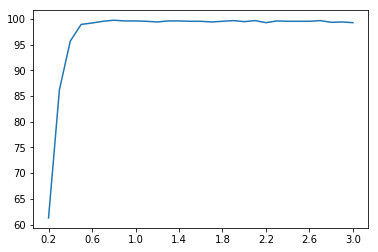

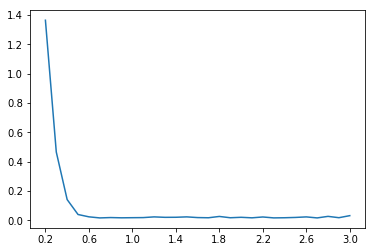

In [10]:
snr=np.linspace(0.2,3,29)
ac=[]
error=[]
for i in range(29):
    print(snr[i])
    test=generator_f(testsig,1480,snr[i],X,Y_)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
    print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    ac.append(a)
    error.append(c)
test=generator_f(testsig,1480,0.25,X,Y_)
a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
print('snr=0.25:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,ac)
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,error)
plt.show()